In [1]:
import sys
sys.path.append('../')  
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
input_len, output_len = 20, 10

In [3]:
data = pd.read_csv('../flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split, scaler = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=True)
# features = getFeatures()

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power', 'x_future', 'y_future', 'z_future', 'x_change', 'y_change', 'z_change']


In [4]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 20, 13])
torch.Size([64, 10])


In [5]:
class LSTM_LSTM(nn.Module):
    def __init__(self, hist_input_size, covariates_size, input_len, output_len, lstm_num_hidden, num_layers=1):
        super(LSTM_LSTM, self).__init__()
        self.encoder = nn.LSTM(hist_input_size, lstm_num_hidden, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hist_input_size, lstm_num_hidden, num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_num_hidden + covariates_size, hist_input_size)
        self.input_len = input_len
        self.output_len = output_len

    def forward(self, x_encoder, x_decoder):
        # x: (batch_size, input_len, input_size)
        _, (h, c) = self.encoder(x_encoder)
        xt = x_encoder[:, -1, :].unsqueeze(1)
        outputs = []
        for t in range(self.output_len):
            output, (h, c) = self.decoder(xt, (h, c))
            covariate = x_decoder[:, t, :].unsqueeze(1)
            output = torch.cat([covariate, output], dim=-1)
            output = self.fc(output)
            xt = output
            outputs.append(output[:, :, -1].unsqueeze(2))

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

hist_input_size = len(select_features)
covariate_size = 6
input_len = 20
output_len = 10
hidden_size = 32
num_layers = 1

seq2seq = LSTM_LSTM(hist_input_size, covariate_size, 
                    input_len, output_len, hidden_size, num_layers=num_layers).to(device)

cpu


In [11]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 20
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        hist_inputs = inputs[:, :, :hist_input_size].to(device)
        covariates = inputs[:, :output_len, hist_input_size:].to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(hist_inputs, covariates)
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        
        hist_inputs = inputs[:, :, :hist_input_size].to(device)
        covariates = inputs[:, :output_len, hist_input_size:].to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = seq2seq(hist_inputs, covariates)
            outputs = outputs.squeeze(-1) # (batch_size, output_len)
            loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'LSTM_LSTM_select_covariates_best_model_{input_len}-{output_len}.pt')


Epoch 1/20 [TRAIN]: 100%|██████████| 2258/2258 [00:25<00:00, 88.99it/s, train_loss=0.0023] 


Epoch 1/20, Average Training Loss: 0.005758


Epoch 1/20 [VAL]: 100%|██████████| 756/756 [00:03<00:00, 208.68it/s, val_loss=0.00475]


Epoch 1/20, Average Validation Loss: 0.004179


Epoch 2/20 [TRAIN]: 100%|██████████| 2258/2258 [00:26<00:00, 85.34it/s, train_loss=0.00473]


Epoch 2/20, Average Training Loss: 0.003907


Epoch 2/20 [VAL]: 100%|██████████| 756/756 [00:03<00:00, 206.23it/s, val_loss=0.00435]


Epoch 2/20, Average Validation Loss: 0.003599


Epoch 3/20 [TRAIN]: 100%|██████████| 2258/2258 [00:27<00:00, 81.08it/s, train_loss=0.00129]


Epoch 3/20, Average Training Loss: 0.003647


Epoch 3/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 187.76it/s, val_loss=0.00396]


Epoch 3/20, Average Validation Loss: 0.003309


Epoch 4/20 [TRAIN]: 100%|██████████| 2258/2258 [00:36<00:00, 61.85it/s, train_loss=0.00356]


Epoch 4/20, Average Training Loss: 0.003902


Epoch 4/20 [VAL]: 100%|██████████| 756/756 [00:07<00:00, 100.41it/s, val_loss=0.00465]


Epoch 4/20, Average Validation Loss: 0.004646


Epoch 5/20 [TRAIN]: 100%|██████████| 2258/2258 [00:42<00:00, 53.34it/s, train_loss=0.00384]


Epoch 5/20, Average Training Loss: 0.003487


Epoch 5/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 166.50it/s, val_loss=0.0035] 


Epoch 5/20, Average Validation Loss: 0.003293


Epoch 6/20 [TRAIN]: 100%|██████████| 2258/2258 [00:29<00:00, 77.29it/s, train_loss=0.00294]


Epoch 6/20, Average Training Loss: 0.003248


Epoch 6/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 186.06it/s, val_loss=0.0036] 


Epoch 6/20, Average Validation Loss: 0.003152


Epoch 7/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 78.54it/s, train_loss=0.00194]


Epoch 7/20, Average Training Loss: 0.003169


Epoch 7/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 173.84it/s, val_loss=0.00373]


Epoch 7/20, Average Validation Loss: 0.003051


Epoch 8/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 78.34it/s, train_loss=0.005]  


Epoch 8/20, Average Training Loss: 0.003136


Epoch 8/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 172.51it/s, val_loss=0.00366]


Epoch 8/20, Average Validation Loss: 0.003116


Epoch 9/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 78.54it/s, train_loss=0.00303]


Epoch 9/20, Average Training Loss: 0.003031


Epoch 9/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 159.36it/s, val_loss=0.00332]


Epoch 9/20, Average Validation Loss: 0.002938


Epoch 10/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.13it/s, train_loss=0.00207]


Epoch 10/20, Average Training Loss: 0.003007


Epoch 10/20 [VAL]: 100%|██████████| 756/756 [00:03<00:00, 191.23it/s, val_loss=0.0029] 


Epoch 10/20, Average Validation Loss: 0.002914


Epoch 11/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.17it/s, train_loss=0.00184]


Epoch 11/20, Average Training Loss: 0.002924


Epoch 11/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 182.03it/s, val_loss=0.0036] 


Epoch 11/20, Average Validation Loss: 0.002844


Epoch 12/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 78.63it/s, train_loss=0.00206]


Epoch 12/20, Average Training Loss: 0.002876


Epoch 12/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 186.36it/s, val_loss=0.00374]


Epoch 12/20, Average Validation Loss: 0.002974


Epoch 13/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.90it/s, train_loss=0.00329]


Epoch 13/20, Average Training Loss: 0.002836


Epoch 13/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 188.03it/s, val_loss=0.00356]


Epoch 13/20, Average Validation Loss: 0.002932


Epoch 14/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.92it/s, train_loss=0.00421]


Epoch 14/20, Average Training Loss: 0.002822


Epoch 14/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 187.20it/s, val_loss=0.0041] 


Epoch 14/20, Average Validation Loss: 0.003166


Epoch 15/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.78it/s, train_loss=0.00327]


Epoch 15/20, Average Training Loss: 0.002813


Epoch 15/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 186.99it/s, val_loss=0.00271]


Epoch 15/20, Average Validation Loss: 0.002866


Epoch 16/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.21it/s, train_loss=0.00314]


Epoch 16/20, Average Training Loss: 0.002741


Epoch 16/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 173.46it/s, val_loss=0.0027] 


Epoch 16/20, Average Validation Loss: 0.002798


Epoch 17/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.54it/s, train_loss=0.00209]


Epoch 17/20, Average Training Loss: 0.002726


Epoch 17/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 186.54it/s, val_loss=0.00345]


Epoch 17/20, Average Validation Loss: 0.002912


Epoch 18/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.14it/s, train_loss=0.00354]


Epoch 18/20, Average Training Loss: 0.002683


Epoch 18/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 186.16it/s, val_loss=0.00303]


Epoch 18/20, Average Validation Loss: 0.002678


Epoch 19/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.48it/s, train_loss=0.006]  


Epoch 19/20, Average Training Loss: 0.002712


Epoch 19/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 187.43it/s, val_loss=0.00293]


Epoch 19/20, Average Validation Loss: 0.002665


Epoch 20/20 [TRAIN]: 100%|██████████| 2258/2258 [00:28<00:00, 79.51it/s, train_loss=0.00305]


Epoch 20/20, Average Training Loss: 0.002634


Epoch 20/20 [VAL]: 100%|██████████| 756/756 [00:04<00:00, 186.49it/s, val_loss=0.00293]

Epoch 20/20, Average Validation Loss: 0.002693


In [11]:
features = getFeatures(covariates=True)
print(features[-6:])
print(select_features)

['x_future', 'y_future', 'z_future', 'x_change', 'y_change', 'z_change']
['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']


Test loss: 0.0024378758389502764
MAPE: 21.5001277923584


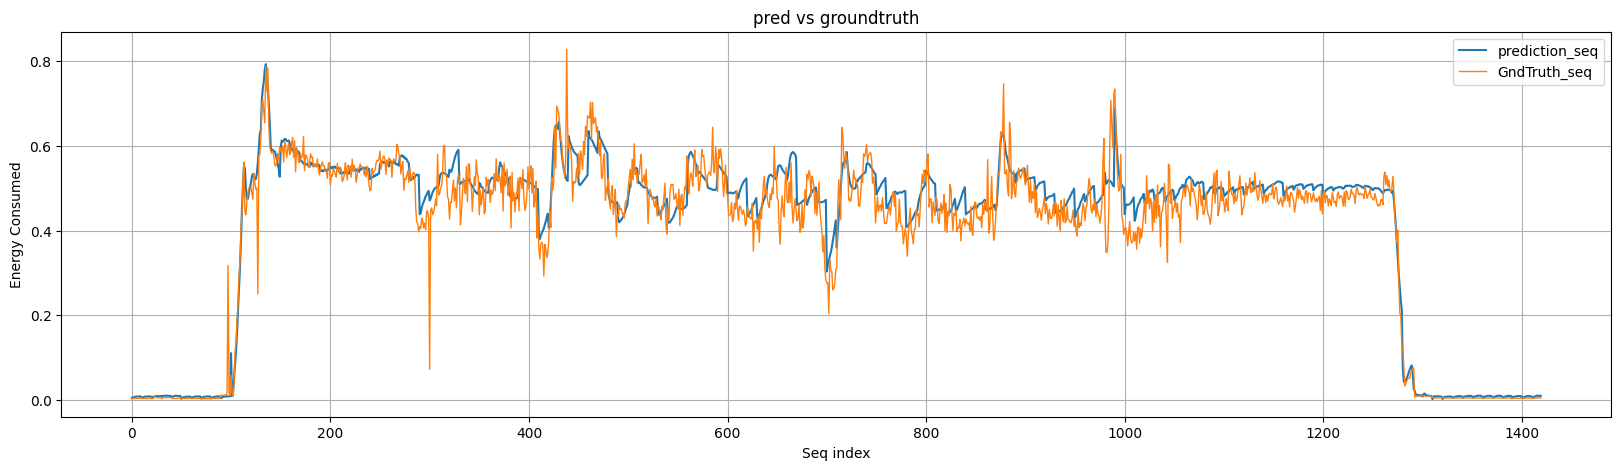

In [13]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'LSTM_LSTM_select_covariates_best_model_{input_len}-{output_len}.pt', map_location=torch.device('cpu')))

# Test the model
seq2seq.eval()
flight_num = 270 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features + features[-6:]].values, 
                                         test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    hist_inputs = input_seq[:, :, :hist_input_size].to(device)
    covariates = input_seq[:, :output_len, hist_input_size:].to(device)
    targets = output_seq.to(device)
    outputs = seq2seq(hist_inputs, covariates)

    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    # print(torch.mean(torch.abs((outputs - targets) / targets)*100,  axis=0))
    print(f"MAPE: {mape}")

    # print(outputs.shape)
    # print(targets.shape)
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [16]:

pytorch_total_params = sum(p.numel() for p in seq2seq.parameters() if p.requires_grad)
print(pytorch_total_params)

10769


In [17]:
features = getFeatures(covariates=False)

In [14]:
from data_process import create_sequences
from utils import plot_output

# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    hist_inputs = inputs[:, :, :hist_input_size].to(device)
    covariates = inputs[:, :output_len, hist_input_size:].to(device)
    targets = targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(hist_inputs, covariates)
        outputs = outputs.squeeze(-1) # (batch_size, output_len)
        # loss = criterion(outputs, targets)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 16.979122375468176


In [28]:
from data_process import create_sequences
from utils import plot_output

# Test the model
seq2seq.eval()
mape_list = []
flights = d_split['test']
# flights.remove(273)
for f_num in d_split['test']:
    test_data = data[(data['flight'] == f_num) &  (data['power'] > 0.05)]
    input_seq, output_seq = create_sequences(test_data[select_features+features[-covariate_size:]].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    # print(f"Flight {f_num}:")

    with torch.no_grad():
        
        hist_inputs = input_seq[:, :, :hist_input_size].to(device)
        covariates = input_seq[:, :output_len, hist_input_size:].to(device)
        targets = targets.to(device)
        outputs = seq2seq(hist_inputs, covariates)

        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq
    
        # error = nn.MSELoss()(outputs, targets)
        # print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        # print(f"MAPE: {mape}")

        mape_list.append(mape)

print(f"Average MAPE: {torch.mean(torch.tensor(mape_list))}")

Average MAPE: 8.408895492553711


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""